# **CIS 520: Machine Learning**

## **Reinforcement Learning**


- **Content Creators:** Mihir Parmar
- **Content Reviewers:**  Shaozhe Lyu, Michael Zhou, Parth Sheth
- **References:**
  - Towards Data Science: https://towardsdatascience.com/reinforcement-learning-cliff-walking-implementation-e40ce98418d4
  - Neuromatch Academy
  - [CIS 522 Course material](https://colab.research.google.com/github/feryal/rl_mlss_2020/blob/master/RL_Tutorial_MLSS_2020.ipynb#scrollTo=xNfVHzosN2P0): I strongly recommend you read this worksheet. It covers SARSA, Q-learning, MDP and DQN in details.

- **Objectives:**

  - Understanding OpenAI's Gym Environment
  - Understanding Q-Learning and Sarsa algorithms
  - Understanding the differences between off-policy and on-policy algorithms

## Initialize Penn Grader

In [1]:
%%capture
!pip install penngrader

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os 
import sys

In [3]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


In [4]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [5]:
import penngrader.grader
grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Reinforcement_Learning_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


## **OpenAI's Gym**

Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or PyTorch.

**We strongly recommend looking over the ["Getting Started" documentation](https://www.gymlibrary.dev/) .**

## *Question 1* 

List at least 5 different environments available in the OpenAI gym suite.
Return answer as a list of strings.(eg.) ans = ["str1","str2","str3","str4","str5])

In [6]:
answers = ["box","discrete","text","graph","sequence"]
grader.grade(test_case_id='test_envs', answer=answers)

Correct! You earned 5.0/5.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Installing Dependencies and Imports**

Let's install gym and some other things to render the environments in Colab.

In [7]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py gym[box2d] > /dev/null 2>&1
!pip install piglet > /dev/null 2>&1

In [8]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
# import tensorflow as tf
# from tensorflow import keras
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os

import matplotlib.animation
import numpy as np
from IPython.display import HTML

# Note, you may get a few warnings regarding Tensorflow and xdpyinfo, these are to be expected

FileNotFoundError: ignored

## **Q-learning vs SARSA in grid worlds**

Firstly, let's gain a bit more intuition for the algorithms we're dealing with by studying them in very simple environments. 

Grid-worlds are simple environments in which an agent navigates a grid, typically aiming to navigate towards goal locations and away from threats. The state variable at its simplest can be a tuple with the agent's location on the grid. 

A more detailed grid world would include the state of the entire grid, like a top-down view of the environment, given as a matrix of $M\times N$ cells.

Here we'll use on- and off-policy TD learning to train an agent to navigate a simple grid world.

This example is based on Example 6.6 of Sutton and Barto. The 'Cliffs' environment implementation comes from [github.com/podondra/gym-gridworlds](https://www.github.com/podondra/gym-gridworlds)

![alt text](https://drive.google.com/uc?export=view&id=16C3NYY7tXl9joVzvwgn5bC3nYl5IJk9M)


The environment works as follows. Reward is -1 on all transition except those into region that is cliff. Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start. The trial is over when the agent reachs the goal location in the opposite bottom corner.

In [9]:
!git clone https://github.com/podondra/gym-gridworlds.git
!pip install gym-gridworlds

import gym_gridworlds

Cloning into 'gym-gridworlds'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
env = gym.make('Cliff-v0')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [11]:
print('Number of actions:', env.action_space)
print('Observation space:', env.observation_space)

Number of actions: Discrete(4)
Observation space: Tuple(Discrete(4), Discrete(12))


## *Question 2*

What do each of the above two variables mean?

In [12]:
action_meaning = "An action performed by the agent"
obs_space_meaning =  "The total space of all valid actions and observations"
grader.grade(test_case_id='test_vars', answer=[action_meaning,obs_space_meaning])

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Recall that the Q-learning and SARSA algorithms are temporal difference (TD) algorithms. They update their estimate of value based on the difference in a current estimate of value and a once-unrolled-into-the-future estimate of value (which we imagine will be slightly more accurate, since we _know_ what the reward is at the next time step).

The SARSA algorithm is on-policy TD learning:
$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t, a_t))
$$
while Q-learning is off-policy:
$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha(r_t + \gamma \max_a Q(s_{t+1},a) - Q(s_t, a_t))
$$

In [13]:
#Our model parameters
total_episodes = 500
K = 10

#Learning rate
alpha = 0.1
#Discount rate
gamma = 0.95
#Exploration proportion
epsilon = 0.05

ny = 4
nx = 12
n_actions = env.action_space.n

It's quite straightforward to train an agent with either algorithm to solve this Cliff environment.

First, we'll define our policies, based on our estimated Q-values:

In [14]:
# SARSA learning (on-policy TD learning
def on_policy(Q, s):
  return np.argmax(Q[s[0], s[1], :])

# Q-learning (off-policy TD learning)
# Epsilon greedy
def off_policy(Q, s, env, epsilon):
  if np.random.random() < epsilon:
    return env.action_space.sample()
  else:
    return np.argmax(Q[s[0], s[1], :])

Now we'll define a simple training loop.

In [15]:
def train(env, policy, total_episodes = 500, run_test = False, test_freq = 10):
  # Set the agent at starting position
  s = env.reset()
  # Initialize Q values
  Q = np.zeros((ny,nx,n_actions))
  cumulative_reward = 0
  n_episodes = 0
  episode_rewards = []
  test_rewards = []
  # Here an episode only ends once we reach the goal location. 
  # So we're training for 500 successful episodes' worth of experience.
  while n_episodes < total_episodes:
    # Select action given current state
    action = policy(Q, s)
    prev_s = s
    # Step the environment forward
    s, reward, done, _ = env.step(action)
    # Now we have our current state, action, next state and reward
    # So we can take our updates
    future_reward = reward + gamma*np.max(Q[s[0], s[1], :])
    expected_future_reward = Q[prev_s[0], prev_s[1], action]
    Q[prev_s[0], prev_s[1], action] += alpha*(future_reward-expected_future_reward)
    cumulative_reward += reward
    # Reset the agent if we're done. Track rewards
    if done:
      if run_test and n_episodes%test_freq == 0:
        test_r = test(env, on_policy, Q)
        test_rewards.append([n_episodes, test_r])
      s = env.reset()
      episode_rewards.append(cumulative_reward)
      n_episodes += 1
      cumulative_reward = 0

  return episode_rewards, Q

We run this a number of times. This will converge quite quickly since it's such a low dimensional state space, action space, and policy.

In [16]:
sarsa_rewards = np.zeros((K, total_episodes))
qlearning_rewards = np.zeros((K, total_episodes))
qpolicy = lambda q,s: off_policy(q, s, env, epsilon)

for idx in range(K):
  # Train with SARSA
  rewards, Q_sarsa = train(env, on_policy, total_episodes)
  sarsa_rewards[idx,:] = rewards
  # Train with Q-learning
  rewards, Q_q = train(env, qpolicy, total_episodes)
  qlearning_rewards[idx,:] = rewards

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed a

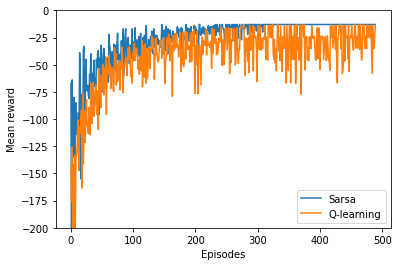

In [17]:
plt.plot(np.mean(sarsa_rewards[:,10:], 0).T)
plt.plot(np.mean(qlearning_rewards[:,10:], 0).T)
plt.legend(['Sarsa', 'Q-learning'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
plt.ylim([-200,0]);

In [18]:
def str_policy(policy):
  string = ''
  # char = {0:up, 1:left, 2:down, 3:right}
  # Unicode renders inconsistent sizes in some browsers...
  # char = {0:u"\u25B2", 1:u"\u25B8", 2:u"\u25BC", 3:u"\u25C0"}
  char = {0:"U", 1:"R", 2:"D", 3:"L"}
  for row in policy:
    string += ' '.join([char[action] for action in row]) + '\n'
  return string

In [19]:
# Plot the policies...
sarsa_policy = np.argmax(Q_sarsa, axis = 2)
print('SARSA policy:\n'+str_policy(sarsa_policy))
q_policy = np.argmax(Q_q, axis = 2)
print('Q-learning policy:\n'+str_policy(q_policy))

SARSA policy:
R L R R L U U R R R D D
U U R R R R R R R R D D
R R R R R R R R R R R D
U U U U U U U U U U U U

Q-learning policy:
D R R R R D R R D R D D
R R R R R D D R R R D D
R R R R R R R R R R R D
U U U U U U U U U U U U



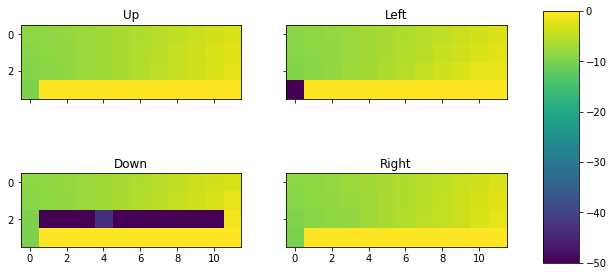

In [20]:
# We can plot the q values too

# For Q-learning
fig, axes = plt.subplots(2,2, figsize = (10,5), sharex = True, sharey = True)
axes[0,0].imshow(Q_q[:,:,0], vmin=-50, vmax=0)
axes[0,0].set_title('Up')
axes[0,1].imshow(Q_q[:,:,1], vmin=-50, vmax=0)
axes[0,1].set_title('Left')
axes[1,0].imshow(Q_q[:,:,2], vmin=-50, vmax=0)
axes[1,0].set_title('Down')
im = axes[1,1].imshow(Q_q[:,:,3], vmin=-50, vmax=0)
axes[1,1].set_title('Right');

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

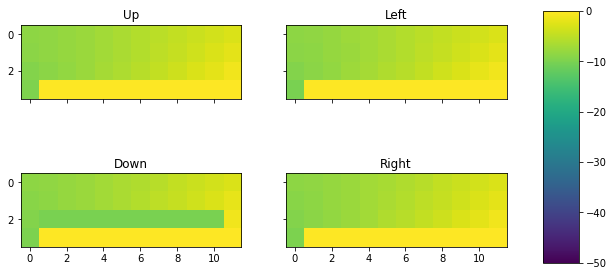

In [21]:
# For SARSA
fig, axes = plt.subplots(2,2, figsize = (10,5), sharex = True, sharey = True)
axes[0,0].imshow(Q_sarsa[:,:,0], vmin=-50, vmax=0)
axes[0,0].set_title('Up')
axes[0,1].imshow(Q_sarsa[:,:,1], vmin=-50, vmax=0)
axes[0,1].set_title('Left')
axes[1,0].imshow(Q_sarsa[:,:,2], vmin=-50, vmax=0)
axes[1,0].set_title('Down')
im = axes[1,1].imshow(Q_sarsa[:,:,3], vmin=-50, vmax=0)
axes[1,1].set_title('Right');

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

In [22]:
env.close()

## *Question 3*

Vary each of the parameters in {number of episodes, discount rate, exloration factor} and observe how the performance/learnt policy changes. Write down your observations after varying each of the 3 parameters.

In [23]:
num_eps = "Increasing episodes leads to better convergence to mean reward"
disc_rate = "Increasing discount rate leads to slower convergence"
exp_factor = "Increasing exploration factor leads to more oscillation in reward as a function of episodes"
grader.grade(test_case_id='test_effect', answer=[num_eps,disc_rate,exp_factor])

Correct! You earned 3.0/3.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Submitting to the Autograder


Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `Reinforcement_Learning_WS.ipynb` and `Reinforcement_Learning_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: Reinforcement Learning**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 8 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort.